# Setup

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl
import pprint as pp
import pandas as pd
import seaborn as sns

ssl._create_default_https_context = ssl._create_unverified_context

wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"
sex_code = {"woman": "Q6581072",
            "man": "Q6581097"}
sex_code

{'man': 'Q6581072', 'woman': 'Q6581097'}

In [2]:
def sample_for_country(result, sex, subject):
    """
    * result: result of the query
    * sex: "man" or "woman" -> select the field "totman" or "totwoman"
    * subject: label of interest (example: placeofbirthLabel/educatedatLabel)
    """
    #if verbose: print(result) # <---------------- emergency debug
    country_info = {}
    for person in result:
        subject_field = person[subject]["value"]

        country = person["countryLabel"]["value"]
        n_birth = person[f"tot{sex}"]["value"]

        if country not in country_info:
            country_info[country] = []
        country_info[country].append((subject_field, n_birth))

    
    tot_pp_per_country = {}
    for country in country_info:
        total_birth_per_country = sum([int(n) for _,n in country_info[country]])
        tot_pp_per_country[country] = total_birth_per_country
        
    
    return tot_pp_per_country




def get_top_sample_by_women(all_countries, women_sample, men_sample, top=10):
    total = []
    for country in all_countries:

        tot_w = 0
        tot_m = 0 

        if country in women_sample: 
            tot_w = women_sample[country]

        if country in men_sample: 
            tot_m = men_sample[country]

        total.append((country, tot_w, tot_m))

    top_on_women = [(w,m,c) for c,w,m in total]
    top_on_women.sort(reverse=True)
    top_on_women = top_on_women[:top]
    top_on_women = {c:{"women":w, "men":m} for w,m,c in top_on_women}

    return top_on_women


def get_women_man_differences(womenResults, manResults, label):
    """
    Given a result of two sparql querys (for woman and for men), 
    retrieve the differences by sex according to a specific label
    """
    women_data = sample_for_country(womenResults, 
                                   sex="women", 
                                   subject=label)

    men_data = sample_for_country(manResults, 
                                 sex="men", 
                                 subject=label)

    countries_of_data = set(women_data.keys()).union(set(men_data.keys()))
    print("women:\t", len(women_data), "\nmen:\t", len(men_data), "\nunion:\t", len(countries_of_data))

    data_dict = get_top_sample_by_women(countries_of_data, women_data, men_data)
    df = pd.DataFrame.from_dict(data_dict, orient="index").plot.bar()
    return data_dict


def execute_query(query):
    sparql_wd = SPARQLWrapper(wikidata_endpoint, agent='Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36')
    sparql_wd.setQuery(query)
    sparql_wd.setReturnFormat(JSON)
    result = sparql_wd.query().convert()
    return result["results"]["bindings"]


# Place of birth

In [3]:
fembirthplace_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofbirth ?placeofbirthLabel ?countryLabel (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450; 
            wdt:P19 ?placeofbirth.
           ?placeofbirth wdt:P17 ?country.
        ?country wdt:P297 ?countryCode.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofbirth ?placeofbirthLabel ?countryLabel
ORDER BY DESC(?totwomen)
"""

menbirthplace_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofbirth ?placeofbirthLabel ?countryLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450; 
            wdt:P19 ?placeofbirth.
           ?placeofbirth wdt:P17 ?country.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofbirth ?placeofbirthLabel ?countryLabel
ORDER BY DESC(?totmen)
"""


womenbirthplacesResults = execute_query(fembirthplace_query)
menbirthplacesResults = execute_query(menbirthplace_query)

women:	 82 
men:	 139 
union:	 147


{'Germany': {'women': 560, 'men': 2242},
 'Czech Republic': {'women': 422, 'men': 785},
 'United States of America': {'women': 171, 'men': 336},
 'Italy': {'women': 123, 'men': 531},
 'Spain': {'women': 122, 'men': 199},
 'Austria': {'women': 106, 'men': 300},
 'France': {'women': 99, 'men': 624},
 'Poland': {'women': 99, 'men': 369},
 'Russia': {'women': 96, 'men': 215},
 'Ukraine': {'women': 74, 'men': 178}}

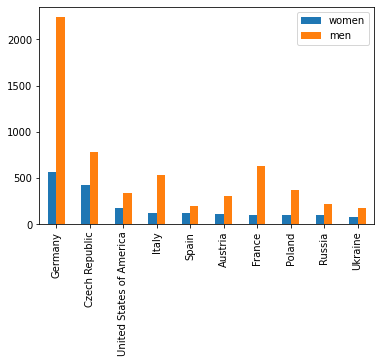

In [4]:
get_women_man_differences(womenResults = womenbirthplacesResults, 
                          manResults = menbirthplacesResults, 
                          label = "placeofbirthLabel")

# Education

In [5]:
educationfem_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?educatedatLabel ?countryLabel  (COUNT(?person) AS ?totwomen)

WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P69 ?educatedat;
            wdt:P27 ?country.
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
    ?educatedat rdfs:label ?educatedatLabel .
    ?country     rdfs:label ?countryLabel .
  
  }

       
}
GROUP BY ?educatedatLabel ?countryLabel
ORDER BY DESC(?totwomen)
"""


eduplaceman_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?educatedatLabel ?countryLabel  (COUNT(?person) AS ?totmen)

WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P69 ?educatedat;
            wdt:P27 ?country.
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
    ?educatedat rdfs:label ?educatedatLabel .
    ?country     rdfs:label ?countryLabel .
  
  }

       
}
GROUP BY ?educatedatLabel ?countryLabel
ORDER BY DESC(?totmen)
"""


educationfemResults = execute_query(educationfem_query)
educationmanResults = execute_query(eduplaceman_query)

women:	 87 
men:	 129 
union:	 149


{'United States of America': {'women': 487, 'men': 684},
 'France': {'women': 143, 'men': 446},
 'Germany': {'women': 125, 'men': 519},
 'Spain': {'women': 123, 'men': 147},
 'United Kingdom': {'women': 108, 'men': 440},
 'Soviet Union': {'women': 105, 'men': 216},
 'Poland': {'women': 90, 'men': 196},
 'Russia': {'women': 66, 'men': 95},
 'Canada': {'women': 49, 'men': 57},
 'Italy': {'women': 42, 'men': 135}}

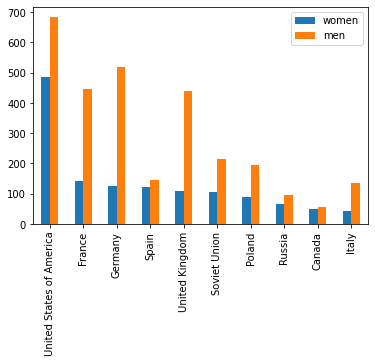

In [6]:
get_women_man_differences(womenResults = educationfemResults,
                          manResults = educationmanResults,
                          label = "educatedatLabel")

# Citizenship

In [7]:
countryfem_query= """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?countryLabel ?citizenshipLabel (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P27 ?citizenship.
       
       ?citizenship wdt:P297 ?countryLabel.
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?countryLabel ?citizenshipLabel
ORDER BY DESC(?totwomen)
"""



countrymen_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?countryLabel ?citizenshipLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P27 ?citizenship.
       
       ?citizenship wdt:P297 ?countryLabel.
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?countryLabel ?citizenshipLabel
ORDER BY DESC(?totmen)
"""


femcountryResults = execute_query(countryfem_query)
mencountryResults = execute_query(countrymen_query)

women:	 76 
men:	 68 
union:	 86


{'DE': {'women': 474, 'men': 1887},
 'US': {'women': 361, 'men': 595},
 'FR': {'women': 202, 'men': 776},
 'IT': {'women': 161, 'men': 364},
 'ES': {'women': 154, 'men': 241},
 'SI': {'women': 136, 'men': 102},
 'PL': {'women': 123, 'men': 260},
 'GB': {'women': 111, 'men': 391},
 'AT': {'women': 103, 'men': 340},
 'RU': {'women': 81, 'men': 102}}

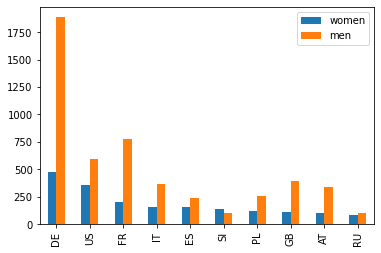

In [8]:
get_women_man_differences(womenResults = femcountryResults,
                          manResults = mencountryResults,
                          label = "citizenshipLabel")

# workplace

In [9]:
feminstitute_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?institutionLabel ?countryLabel  (count(?person) as ?totwomen) WHERE {
  
  ?person wdt:P31 wd:Q5; 
             wdt:P21 wd:Q6581072;
            wdt:P106/wdt:P279* wd:Q1792450;
             wdt:P463 ?institution.
            ?institution wdt:P17 ?country.
    ?country wdt:P297 ?countryCode.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
}

GROUP BY ?institutionLabel  ?countryLabel
ORDER BY DESC (?totwomen)
"""


maleinstitute_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?institutionLabel ?countryLabel  (count(?person) as ?totmen) WHERE {
  
  ?person wdt:P31 wd:Q5; 
             wdt:P21 wd:Q6581097;
            wdt:P106/wdt:P279* wd:Q1792450;
             wdt:P463 ?institution.
            ?institution wdt:P17 ?country.
    ?country wdt:P297 ?countryCode.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
}

GROUP BY ?institutionLabel  ?countryLabel
ORDER BY DESC (?totmen)
"""

feminstituteResults = execute_query(feminstitute_query)
maleinstituteResults = execute_query(maleinstitute_query)

women:	 33 
men:	 46 
union:	 47


{'Germany': {'women': 96, 'men': 911},
 'United States of America': {'women': 80, 'men': 242},
 'Spain': {'women': 40, 'men': 182},
 'United Kingdom': {'women': 32, 'men': 206},
 'France': {'women': 31, 'men': 331},
 'Italy': {'women': 22, 'men': 173},
 'Sweden': {'women': 16, 'men': 132},
 'Austria': {'women': 11, 'men': 122},
 'Poland': {'women': 8, 'men': 78},
 'Belgium': {'women': 8, 'men': 49}}

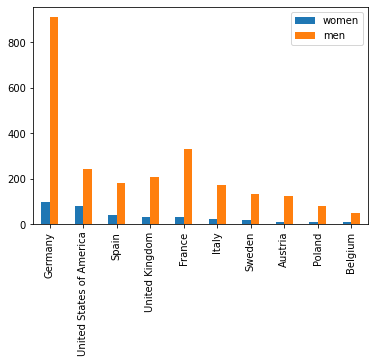

In [10]:
get_women_man_differences(womenResults = feminstituteResults,
                          manResults = maleinstituteResults,
                          label = "institutionLabel")

# Place of death

In [11]:
placeofdeathfem_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofdeath ?placeofdeathLabel ?countryLabel (COUNT(?person) AS ?totwomen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581072 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P20 ?placeofdeath;
            wdt:P27 ?country.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofdeath ?placeofdeathLabel ?countryLabel
ORDER BY DESC(?totwomen)
"""

placeofdeathman_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
SELECT DISTINCT ?placeofdeath ?placeofdeathLabel ?countryLabel (COUNT(?person) AS ?totmen)
WHERE
{
       ?person wdt:P31 wd:Q5 ;
            wdt:P21 wd:Q6581097 ;
            wdt:P106/wdt:P279* wd:Q1792450;
            wdt:P20 ?placeofdeath;
            wdt:P27 ?country.
       
       SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}
GROUP BY ?placeofdeath ?placeofdeathLabel ?countryLabel
ORDER BY DESC(?totmen)
"""

deathfemResults = execute_query(placeofdeathfem_query)
deathmanResults = execute_query(placeofdeathman_query)

women:	 68 
men:	 141 
union:	 148


{'Germany': {'women': 91, 'men': 970},
 'United States of America': {'women': 83, 'men': 231},
 'Czechoslovakia': {'women': 53, 'men': 202},
 'France': {'women': 45, 'men': 454},
 'Soviet Union': {'women': 39, 'men': 147},
 'Italy': {'women': 37, 'men': 170},
 'Austria': {'women': 36, 'men': 185},
 'Poland': {'women': 33, 'men': 118},
 'Kingdom of Italy': {'women': 31, 'men': 222},
 'United Kingdom': {'women': 26, 'men': 143}}

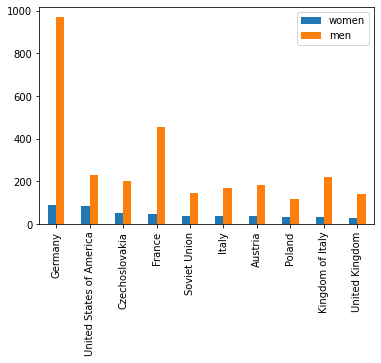

In [12]:
get_women_man_differences(womenResults = deathfemResults,
                          manResults = deathmanResults,
                          label = "placeofdeathLabel")